preprocessing_v0.ipynb 파일에서 수정한 부분이 있어서 함께 깃허브에 올립니다. <br>
다음을 수정해서 사용했습니다: <br>
- 'n_non_stop_words_rounded' 열 삭제
- 결측치 처리 셀을 한 칸 위로 이동
- (위의 두 가지를 반영한 PCA 결과 확인)
- 마지막 셀 추가 (중요도 순서 feature list를 복사, 붙여넣기 하기 위해서 추가)

<a href="https://colab.research.google.com/github/leehimcm/feature_selection/blob/main/preprocessing_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 작업 디렉토리 변경
import os
print(os.getcwd(), end=' -> ')
os.chdir('/content/drive/MyDrive/PatternRecognition/project')
print(os.getcwd())

/content/drive/My Drive/PatternRecognition/project -> /content/drive/MyDrive/PatternRecognition/project


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# CSV 파일 불러오기
df = pd.read_csv('train.csv')
df.head()

,id,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,data_channel,weekday,shares,y
0,17335,9.0,409.0,0.501326,1.0,0.587361,23.0,2.0,11.0,0.0,...,-0.1875,-0.1,0.50,0.500,0.00,0.500,Lifestyle,NaN,801,0
1,21242,10.0,317.0,0.725086,1.0,0.830097,6.0,3.0,NaN,21.0,...,-0.6000,NaN,0.00,0.000,0.50,0.000,Lifestyle,Tuesday,426,0
2,9448,11.0,447.0,0.584091,1.0,0.730104,NaN,1.0,1.0,1.0,...,-0.5000,-0.1,0.75,0.125,0.25,0.125,World,Friday,2400,1
3,36797,13.0,143.0,0.638298,NaN,0.787500,3.0,2.0,NaN,0.0,...,0.0000,0.0,1.00,NaN,0.50,0.500,Social Media,NaN,1100,0
4,29504,17.0,576.0,0.524412,1.0,0.714286,8.0,3.0,NaN,0.0,...,-1.0000,-0.1,0.00,0.000,0.50,0.000,World,Wednesday,1500,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22200 entries, 0 to 22199
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            22200 non-null  int64  
 1   n_tokens_title                20000 non-null  float64
 2   n_tokens_content              20054 non-null  float64
 3   n_unique_tokens               19942 non-null  float64
 4   n_non_stop_words              20017 non-null  float64
 5   n_non_stop_unique_tokens      19944 non-null  float64
 6   num_hrefs                     19967 non-null  float64
 7   num_self_hrefs                19920 non-null  float64
 8   num_imgs                      19986 non-null  float64
 9   num_videos                    19906 non-null  float64
 10  average_token_length          19987 non-null  float64
 11  num_keywords                  19955 non-null  float64
 12  kw_min_min                    19984 non-null  float64
 13  k

(0.0, 20000.0)

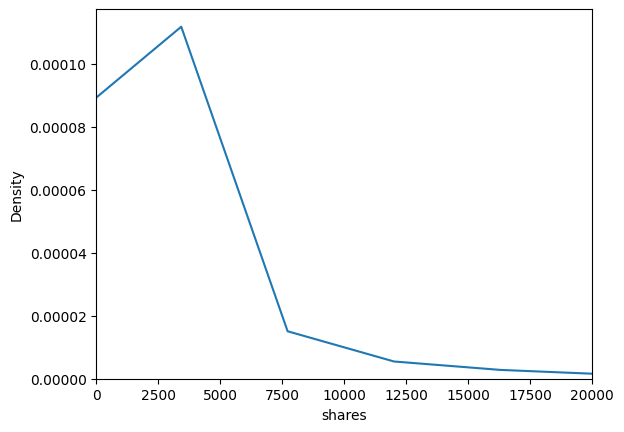

In [ ]:
# 공유 수 분포 그래프
sns.kdeplot(df['shares'])
plt.xlim(0, 20000)

# 데이터 전처리

In [ ]:
# 가장 많이 등장한 값이 전체에서 차지하는 비율 top 10
top_ratio_dict = {}

for col in df.columns:
    most_common = df[col].value_counts(dropna=False).iloc[0]
    total = len(df)
    ratio = most_common / total
    top_ratio_dict[col] = ratio

top_10 = sorted(top_ratio_dict.items(), key=lambda x: x[1], reverse=True)[:10]

for col, ratio in top_10:
    print(f"{col}: {ratio:.2%}")

kw_max_max: 68.41%
num_videos: 56.30%
kw_min_min: 51.76%
y: 50.43%
abs_title_subjectivity: 46.68%
title_sentiment_polarity: 45.55%
abs_title_sentiment_polarity: 45.47%
num_imgs: 41.08%
title_subjectivity: 40.79%
kw_min_avg: 39.03%


In [ ]:
# 중복 값이 많은 변수들을 자세히 살펴보자
df['kw_min_min'].value_counts(dropna=False).head(5)

,count
kw_min_min,
-1.0,11491
4.0,6074
217.0,2367
NaN,2216
0.0,34


In [ ]:
df['kw_max_max'].value_counts(dropna=False).head(5)

,count
kw_max_max,
843300.0,15186
NaN,2232
690400.0,2017
617900.0,1143
69100.0,654


In [ ]:
df['n_non_stop_words_rounded'] = df['n_non_stop_words'].round(3)  # 소수 셋째 자리까지 반올림
df['n_non_stop_words_rounded'].value_counts(dropna=False)

,count
n_non_stop_words_rounded,
1.0,19420
NaN,2183
0.0,597


In [ ]:
# 많은 값들이 같은 값을 가지므로 삭제한다
df.drop(columns=['kw_min_min'], axis=1, inplace=True)
df.drop(columns=['kw_max_max'], axis=1, inplace=True)
df.drop(columns=['n_non_stop_words'], axis=1, inplace=True)

In [ ]:
# 반올림 하는 데에 사용한 변수이므로 또한 삭제
df.drop(columns=['n_non_stop_words_rounded'], axis=1, inplace=True)

In [ ]:
# 'id'는 학습에 사용할 값이 아니므로 삭제한다
df.drop(columns=['id'], axis=1, inplace=True)

In [ ]:
# 요일별 shares의 평균, 최댓값, 최솟값
weekday_stats = df.groupby('weekday')['shares'].agg(
    avg_shares=lambda x: round(x.mean(), 2),
    max_shares='max',
    min_shares='min'
).reset_index()

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_stats['weekday'] = pd.Categorical(weekday_stats['weekday'], categories=weekday_order, ordered=True)
weekday_stats = weekday_stats.sort_values('weekday')
print(weekday_stats)

     weekday  avg_shares  max_shares  min_shares
1     Monday     3574.82      652900          43
5    Tuesday     3139.31      208300          42
6  Wednesday     3432.23      843300          48
4   Thursday     3225.35      298400          22
0     Friday     3152.97      233400          28
2   Saturday     4544.41      617900          49
3     Sunday     3937.87       83300         171


In [ ]:
# 결측치 처리
for col in df.columns:
    if df[col].dtype == 'object': # 범주형 → 최빈값
        df[col].fillna(df[col].mode()[0], inplace=True)
    else: # 숫자형 → 중간값
        df[col].fillna(df[col].median(), inplace=True)

<ipython-input-33-6a0114ce1937>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-33-6a0114ce1937>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [ ]:
# is_weekend 변수 추가
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday']).astype(int)

# 범주형 데이터 One-Hot Encoding
df = pd.get_dummies(df, columns=['data_channel', 'weekday'], drop_first=True)

In [ ]:
# 입력 변수(X), 라벨(y) 분리
X = df.drop(columns=['shares', 'y'])
y = np.log1p(df['shares'])  # log(1 + shares) -> shares=0 일 경우 에러 방지

# 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


여기까지 코드 그대로 쓰면 됩니다



---





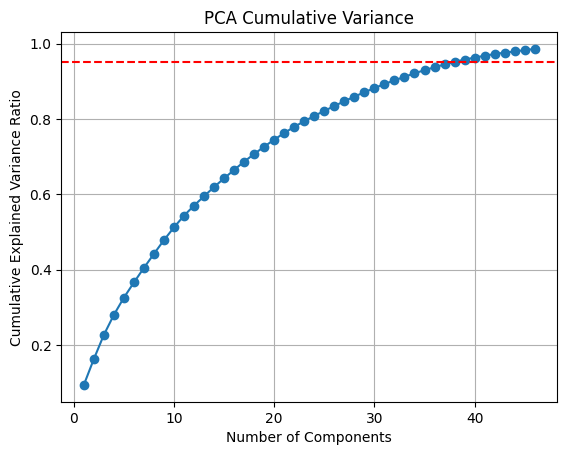

In [ ]:
# PCA 적용
pca = PCA(n_components=46)
pca.fit(X_scaled)

# 누적 분산 시각화
cumulative_variance = pca.explained_variance_ratio_.cumsum()

plt.plot(range(1, 47), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Cumulative Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--')  # 95%
plt.show()

In [ ]:
# PC1 ~ PC35까지만 사용
loadings = pca.components_[:35]                           # shape: (35, n_features)
explained_var = pca.explained_variance_ratio_[:35]        # shape: (35,)

feature_names = X.columns

# 중요도 계산
weighted_loadings = np.abs(loadings) * explained_var[:, np.newaxis]  # broadcasting
importance_score = weighted_loadings.sum(axis=0)  # 변수별 중요도

# 정렬
importance_series = pd.Series(importance_score, index=feature_names)
important_features_ranked = importance_series.sort_values(ascending=False)

print(important_features_ranked)

data_channel_Lifestyle          0.105882
kw_avg_max                      0.105050
global_rate_positive_words      0.103980
kw_min_avg                      0.102922
data_channel_World              0.101893
min_positive_polarity           0.100684
LDA_00                          0.099414
min_negative_polarity           0.098563
num_hrefs                       0.097835
LDA_02                          0.097004
global_rate_negative_words      0.096927
self_reference_min_shares       0.096850
num_keywords                    0.096616
data_channel_Tech               0.094334
LDA_01                          0.093871
kw_max_avg                      0.093652
self_reference_max_shares       0.093255
LDA_04                          0.093170
LDA_03                          0.093159
num_self_hrefs                  0.093025
kw_max_min                      0.092244
num_videos                      0.090709
abs_title_sentiment_polarity    0.090656
rate_positive_words             0.090213
num_imgs        

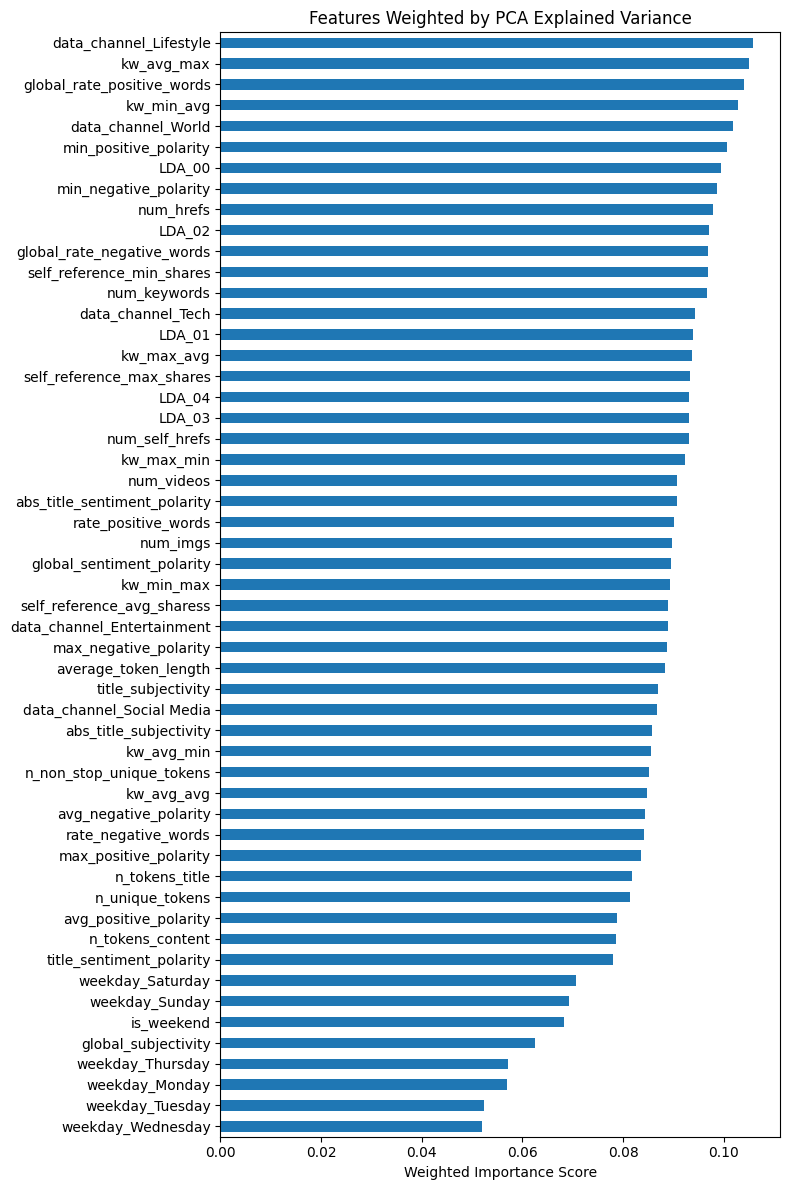

In [ ]:
# 시각화
important_features_ranked.plot(kind='barh', figsize=(8, 12))
plt.title("Features Weighted by PCA Explained Variance")
plt.xlabel("Weighted Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# feature selection에 사용하기 위해 리스트로 출력
important_features_ranked.index.to_list()

['data_channel_Lifestyle',
 'kw_avg_max',
 'global_rate_positive_words',
 'kw_min_avg',
 'data_channel_World',
 'min_positive_polarity',
 'LDA_00',
 'min_negative_polarity',
 'num_hrefs',
 'LDA_02',
 'global_rate_negative_words',
 'self_reference_min_shares',
 'num_keywords',
 'data_channel_Tech',
 'LDA_01',
 'kw_max_avg',
 'self_reference_max_shares',
 'LDA_04',
 'LDA_03',
 'num_self_hrefs',
 'kw_max_min',
 'num_videos',
 'abs_title_sentiment_polarity',
 'rate_positive_words',
 'num_imgs',
 'global_sentiment_polarity',
 'kw_min_max',
 'self_reference_avg_sharess',
 'data_channel_Entertainment',
 'max_negative_polarity',
 'average_token_length',
 'title_subjectivity',
 'data_channel_Social Media',
 'abs_title_subjectivity',
 'kw_avg_min',
 'n_non_stop_unique_tokens',
 'kw_avg_avg',
 'avg_negative_polarity',
 'rate_negative_words',
 'max_positive_polarity',
 'n_tokens_title',
 'n_unique_tokens',
 'avg_positive_polarity',
 'n_tokens_content',
 'title_sentiment_polarity',
 'weekday_Saturd